In [1]:
%pylab inline
import torch
from torch.autograd import Variable
from torch import nn
import loader
from threes import *
from qLearningNet import *
import time
from AIModels import *
from replayMemory import *


MOVES = [0, 1, 2, 3]

FILENAME = "saved_parameters"
INPUT_SIZE = 19
HIDDEN_SIZE = 256


def testNet(filename=None, net=None):
    game = Threes(save_game=False)
    if filename is not None:
        ai = QLearningNetAI(game, filename=filename)
    elif net is not None:
        ai = QLearningNetAI(game, net=net)
    scores, move_count, highs = AIModel.test_ai(ai, 100, verbose=False)
    return move_count, np.mean(scores), np.mean(highs)


# parametry sieci np. learning rate
# lepszy zbior uczacy - jak w DeepMindzie
# nagrody - musza byc wieksze - inaczej sami sobie redukujemy learning rate
# (gestsze nagrody - np. logarytm z rewardow)
# uczyc jednak dobrymi przebiegami
# http://pytorch.org/docs/master/nn.html#embedding 
# nagrody za mergowane klocki, wykres wartosci Q

Populating the interactive namespace from numpy and matplotlib


In [2]:
def train(model, data_loaders, optimizer, num_epochs=500, log_every=100, verbose=True, batch_size=100, \
          use_memory=True, gamma=0.8):
    replays = ReplayMemory(10**5)
        
    results = []
    losses = []
    
    epoch = 0
    if verbose:
        print u'Training the model!'
        print u'Interrupt at any time to get current model'
    try:
        while epoch < num_epochs:
            epoch += 1
            new_data = data_loaders.get(model, batch_size)
            if use_memory:
                replays.add(new_data)
                x = replays.choose(batch_size)
            else:
                x = new_data
            
            future = x[:, 21:]
            future_scores = model.Q(future)
            for i, row in enumerate(future):
                game = Threes(save_game=False, data=row.tolist())
                for j, move in enumerate(MoveEnum):
                    if not game.canMove(move):
                        future_scores[i, j] = float('-inf')
                if not game.getPossibleMoves():
                    future_scores[i:,:] = np.full((1,4), x[i, 20])
                
            y = x[:, 20] + gamma * np.max(future_scores, axis=1)
            xx = x[:, :19]

            optimizer.zero_grad()
            i = np.asarray(np.vstack((np.arange(0,batch_size),x[:,19])),int)
            
            i = torch.LongTensor(i)
            out = model.Q(xx, as_variable=True)[i[0],i[1]]
            loss = model.loss(out, y)
            loss.backward()
            optimizer.step()

            if epoch % log_every == 0 and verbose:
                #print replays.data.shape
                print u"Minibatch {0: >6}  | loss {1: >15.12f} ".format(epoch, loss.data[0])
                result = testNet(net=model)
                print u"The average score was {}".format(result[1])
                results += [result[1]]
                losses += [loss.data.numpy()]
            if epoch % (log_every * 20) == 0:
                result = testNet(net=model)
                filename = FILENAME +'{}_{}'.format(epoch, int(result[1]))
                model.save_parameters(filename)
                

    except KeyboardInterrupt:
        pass
    result = testNet(net=model)
    filename = FILENAME +'{}_{}'.format(epoch, int(result[1]))
    model.save_parameters(filename)
    return results, losses

In [3]:
q_learning_net = QLearningNet()
for p in q_learning_net.network.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(q_learning_net.network.parameters(), lr=5.0)
data_loader = loader.Loader()
scores, loses = train(q_learning_net, data_loader, optimizer, num_epochs=20000)
print("Learning done")
# save scores, loses to file?

Training the model!
Interrupt at any time to get current model
Minibatch    100  | loss 17.698392868042 
The average score was 230.64
Minibatch    200  | loss  0.009933513589 
The average score was 393.12
Minibatch    300  | loss  0.000000643971 
The average score was 442.71
Minibatch    400  | loss  0.000000052684 
The average score was 422.1
Minibatch    500  | loss 187.037750244141 
The average score was 406.02
Minibatch    600  | loss 1281.553955078125 
The average score was 347.01
Minibatch    700  | loss 55.505104064941 
The average score was 417.54
Minibatch    800  | loss  0.000101445017 
The average score was 351.51
Minibatch    900  | loss  0.000179763476 
The average score was 377.58
Minibatch   1000  | loss  0.000007315018 
The average score was 450.66
Minibatch   1100  | loss  0.000000639947 
The average score was 395.22
Minibatch   1200  | loss  0.000226607168 
The average score was 419.67
Minibatch   1300  | loss  0.369380146265 
The average score was 438.42
Minibatch   

In [5]:
np.savetxt('scores', scores)
np.savetxt('loses', loses)

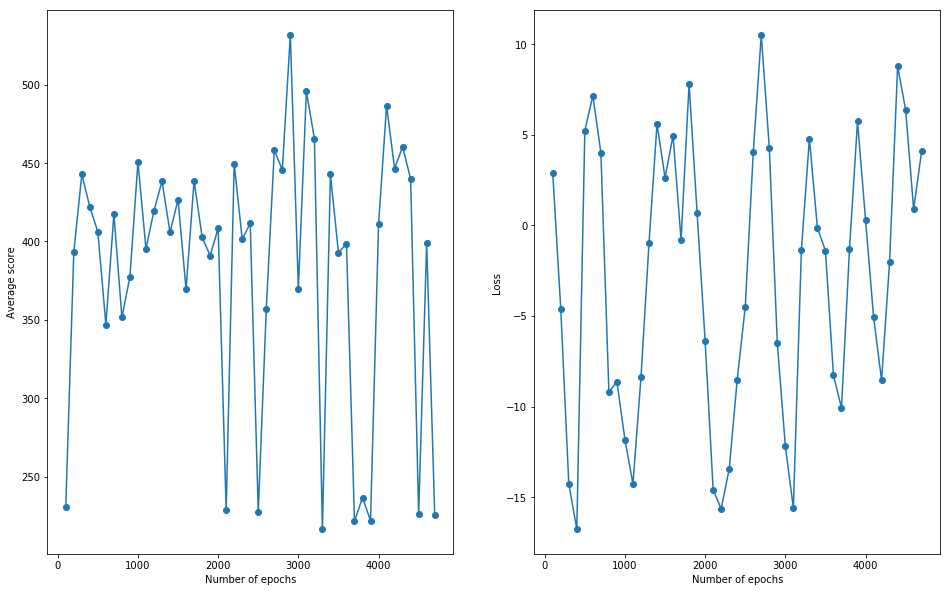

In [6]:
figure()
figsize(16, 10)
subplot(1,2,1)
plot(range(100,len(scores)*100+1, 100), scores, marker='o')
xlabel('Number of epochs')
ylabel('Average score')
subplot(1,2,2)
plot(range(100,len(scores)*100+1, 100), np.log(loses), marker='o')
xlabel('Number of epochs')
ylabel('Loss')
show()

In [ ]:
filename = FILENAME + '6000_447'
print testNet(filename = filename)

In [ ]:
game = Threes(save_game=False)
ai = RandomAI(game)
scores, move_count, highs = AIModel.test_ai(ai, 1000, verbose=False)
print move_count
print np.mean(scores), np.mean(highs)

In [ ]:
game = Threes(save_game=False)
ai = MiniMaxAI(game)
scores, move_count, highs = AIModel.test_ai(ai, 10, verbose=False)
print move_count
print np.mean(scores), np.mean(highs)